# Workflow for feature testing and comparison

We are testing multiple ways to describe the calibration information in order to find suitable features to solve this classification problem.
Therefore, we have generated a workflow where feature testing can be done, and the modelling performance with (at least) three different classification algorithm are reported in an excel file (modelling_results.csv). To keep the results comparable, the exact same workflow is used for testing in order to avoid reporting differences due to randomization and different splitting of the training and test set.

## Libraries and read in cleaned data

Data cleaning (done by Yvonne) and following steps were taken:
- removing rows with nan in RT
- removing rows with nan in concentration
- removing calibration graphs with only 1 or 2 calibration points

Data set contains 3860 rows and no nan values


In [14]:
# libraries
import pandas as pd
import numpy as np
from plotnine import *

# data
file_path = "C:/Users/HelenSepman/OneDrive - Kruvelab/Documents/GitHub/ML_calibration_graph_linearity/0_data/data_ready_addfeatures_231122.csv"
#file_path = ".../ML_calibration_graph_linearity/0_data/data_ready_231029.csv"
df_calibrations = pd.read_csv(file_path)
df_calibrations.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3860 entries, 0 to 3859
Data columns (total 26 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   lab                  3860 non-null   object 
 1   compound             3860 non-null   object 
 2   sample_type          3860 non-null   object 
 3   RT                   3860 non-null   float64
 4   sample               3860 non-null   object 
 5   peak_area            3860 non-null   float64
 6   note                 3860 non-null   object 
 7   c_real_M             3860 non-null   float64
 8   rf                   3860 non-null   float64
 9   rf_error             3860 non-null   float64
 10  slope                3860 non-null   float64
 11  intercept            3860 non-null   float64
 12  residuals            3860 non-null   float64
 13  abs_residuals        3860 non-null   float64
 14  peak_area_norm1      3860 non-null   float64
 15  c_real_M_norm1       3860 non-null   f

## Feature engineering

Define features used for modelling here

In [19]:
# new features
#logarithmic c and area + normalized; calc RF from those
df_cal = df_calibrations
df_cal['log10_conc'] = np.log10(df_calibrations['c_real_M'])
#remove 0 values for area
df_cal = df_cal[(df_cal['peak_area'] > 0)]
df_cal['log10_area'] = np.log10(df_cal['peak_area'])

#RF
df_cal['log10_RF'] = df_cal['log10_area'] / df_cal['log10_conc']

#normalize 1 does not work here?
#df_cal['log10_conc_norm1'] = df_cal.groupby(['lab', 'compound'])['log10_conc'].transform(lambda x: x / x.max())
#df_cal['log10_area_norm1'] = df_cal.groupby(['lab', 'compound'])['log10_area'].transform(lambda x: x / x.max())


## clarithomycin_Na in L2 - conc == peak area????

C:\Users\HelenSepman\AppData\Local\Temp\ipykernel_22500\2413620612.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\HelenSepman\AppData\Local\Temp\ipykernel_22500\2413620612.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
from sklearn.preprocessing import MinMaxScaler

columns_to_scale = ['log10_conc', 'log10_area', 'log10_RF']

scaler = MinMaxScaler()

def scale_columns(group):
    for col in columns_to_scale:
        group[f'{col}_norm2'] = scaler.fit_transform(group[[col]])
    return group


df_cal = df_cal.groupby(['lab', 'compound']).apply(scale_columns)


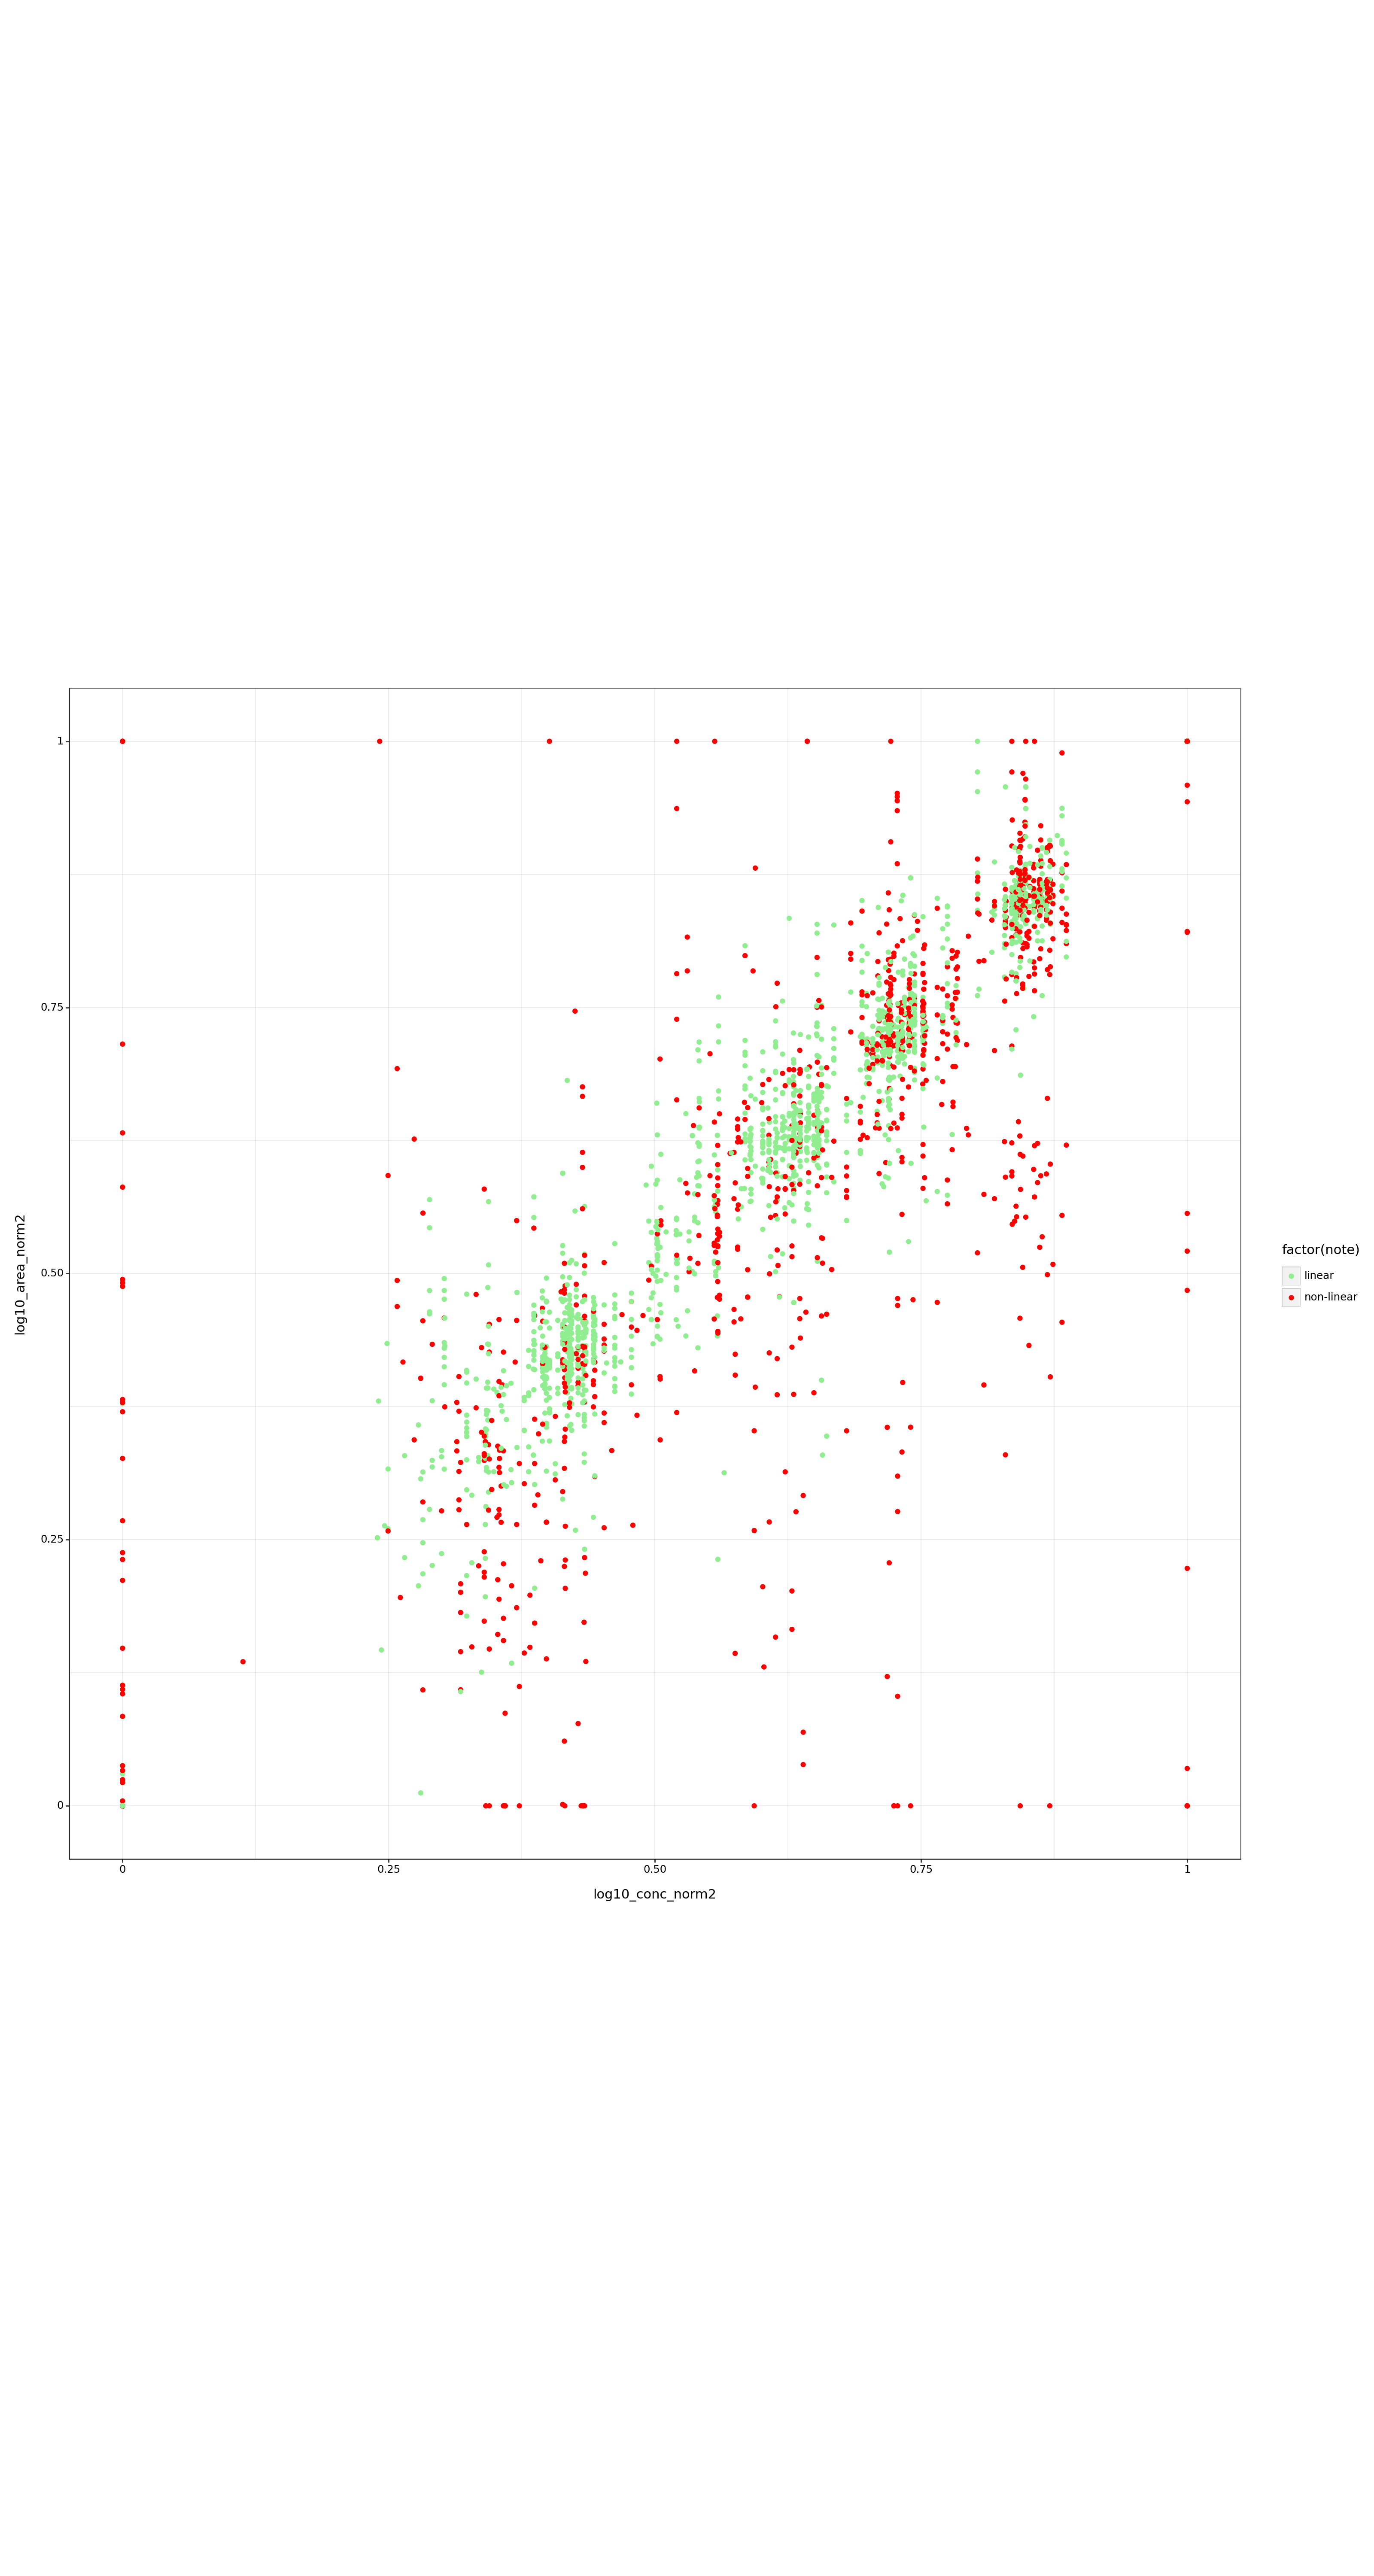

<Figure Size: (1600 x 3000)>

In [24]:

# Plotting, if needed
fig = (
    ggplot(data = df_cal,
          mapping = aes(x = 'log10_conc_norm2', y = 'log10_area_norm2')) +
    geom_point(aes(color = "factor(note)")) +
    scale_color_manual(values=("lightgreen", "red")) +
    theme_bw() +
    #scale_y_log10() +
    #scale_x_log10() + 

    theme(figure_size = (16, 30),
          axis_line = element_line(size = 0.5, colour = "black"),
          panel_grid_major = element_line(size = 0.05, colour = "black"),
          panel_grid_minor = element_line(size = 0.05, colour = "black"),
          axis_text = element_text(colour ='black'),
          aspect_ratio=1
          ) 
)
fig

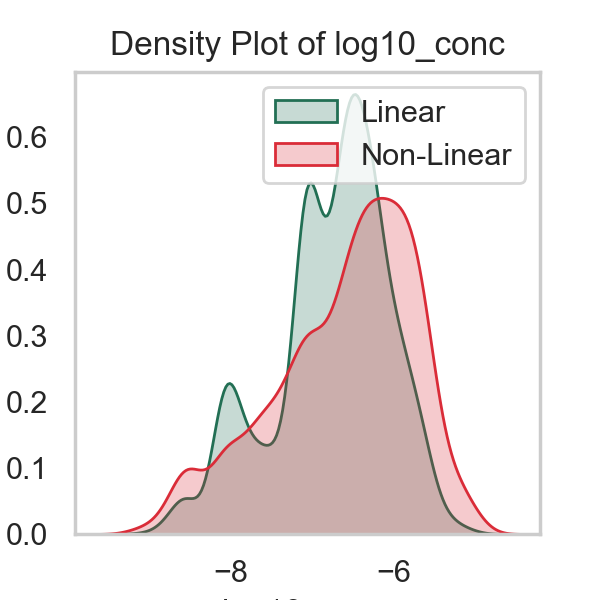

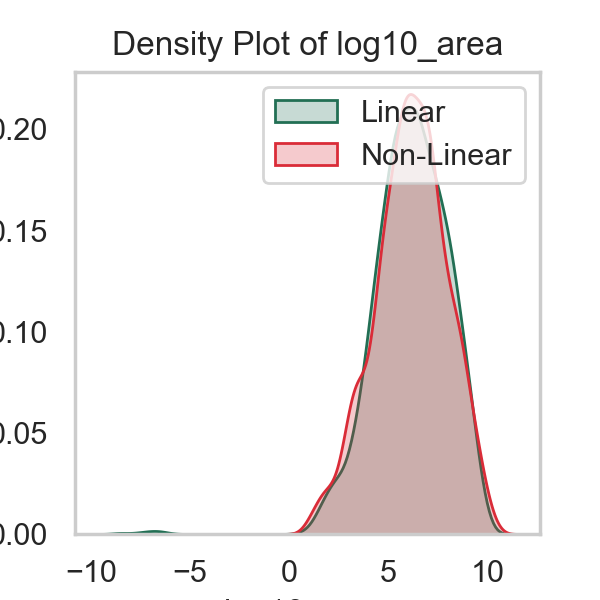

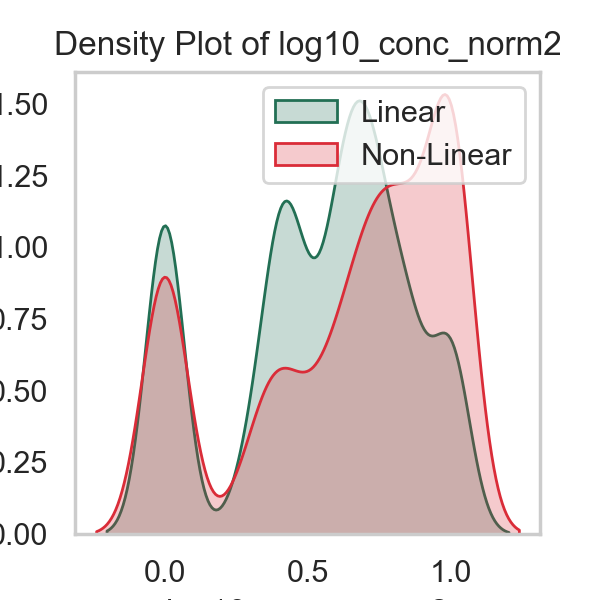

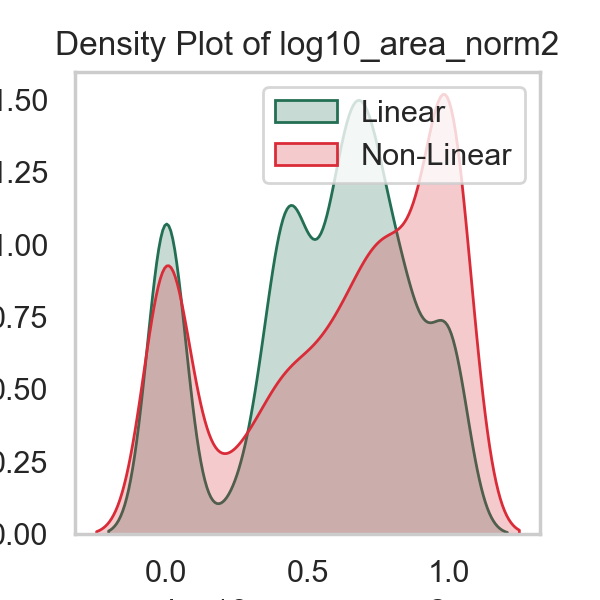

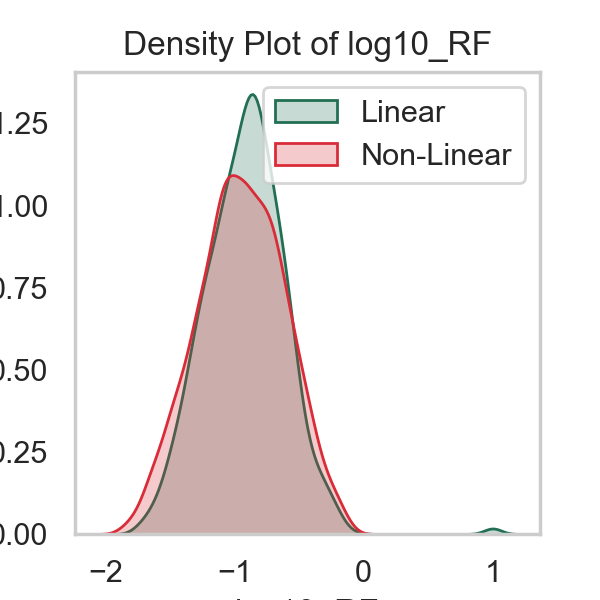

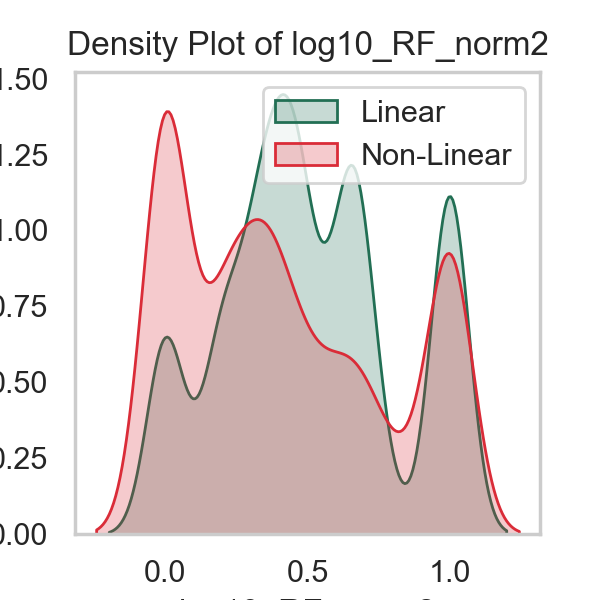

In [25]:
# Here we should maybe add the density plots that Yvonne was also showing to show if there is a potential in classification
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


columns_to_plot = ['log10_conc', 'log10_area', 'log10_conc_norm2', 'log10_area_norm2', 'log10_RF', 'log10_RF_norm2']


sns.set(style="whitegrid")
colors = {'linear': '#226f54', 'non-linear': '#da2c38'}


for column in columns_to_plot:
    plt.figure(figsize=(3,3))
    
    # Plot density functions colored by 'note'
    # sns.kdeplot(data=df_cal, x=column, hue='note', fill=True, common_norm=False)
    sns.kdeplot(data=df_cal, x=column, hue='note', fill=True, common_norm=False,
                palette=colors)
    plt.legend(labels=['Linear', 'Non-Linear'], loc='upper right')
    plt.grid(False)
    plt.title(f'Density Plot of {column}')
    
    plt.show()

## Modelling

Using default values here

- Decision Tree
- KNN
- Random Forest
- xgboost?

In [27]:
# Split dataset into features and target variable
df_calibrations = df_cal
X = df_calibrations[['log10_conc_norm2','log10_area_norm2','log10_RF_norm2']]
y = df_calibrations[['note']]

In [28]:
from sklearn.model_selection import train_test_split

# Split dataset into training set and test set
np.random.seed(123)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1) # 80% training and 20% test

print(X_train.shape) #(3134, 3)
print(y_train.shape) #(3134, 1)
print(X_test.shape) #(784, 3)
print(y_test.shape) #(784, 1)

(3086, 3)
(3086, 1)
(772, 3)
(772, 1)


In [31]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

np.random.seed(123) # random seed for consistency
DT_model = DecisionTreeClassifier()

# cross-validate
cv_scores1 = cross_val_score(DT_model, X_train, y_train, cv=5)
print(f'Cross-validation scores of DT: {np.mean(cv_scores1)*100}%')

# train classifiers
DT_model.fit(X_train, y_train)

# predict validation set
X_test['DT_note_pred'] = DT_model.predict(X_test[['log10_conc_norm2','log10_area_norm2','log10_RF_norm2']])

print(f"Accuracy of DT on test set: {DT_model.score(X_test[['log10_conc_norm2','log10_area_norm2','log10_RF_norm2']], y_test[['note']])*100}%")



Cross-validation scores of DT: 64.87346120963215%
Accuracy of DT on test set: 63.98963730569949%


In [32]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

np.random.seed(123) # random seed for consistency
KNN_model = KNeighborsClassifier()

# cross-validate
cv_scores2 = cross_val_score(KNN_model, X_train, y_train['note'], cv=5)
print(f'Cross-validation scores of KNN: {np.mean(cv_scores2)*100}%')

# train classifiers
KNN_model.fit(X_train, y_train['note'])

# predict validation set
X_test['KNN_note_pred'] = KNN_model.predict(X_test[['log10_conc_norm2','log10_area_norm2','log10_RF_norm2']])

print(f"Accuracy of KNN on test set: {KNN_model.score(X_test[['log10_conc_norm2','log10_area_norm2','log10_RF_norm2']], y_test[['note']])*100}%")


Cross-validation scores of KNN: 65.5863269919697%
Accuracy of KNN on test set: 64.76683937823834%


In [33]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

np.random.seed(123) # random seed for consistency
RF_model = RandomForestClassifier()

# cross-validate
cv_scores3 = cross_val_score(RF_model, X_train, y_train['note'], cv=5)
print(f'Cross-validation scores of RF: {np.mean(cv_scores3)*100}%')

# train classifiers
RF_model.fit(X_train, y_train['note'])

# predict validation set
X_test['RF_note_pred'] = RF_model.predict(X_test[['log10_conc_norm2','log10_area_norm2','log10_RF_norm2']])

print(f"Accuracy of RF on test set: {RF_model.score(X_test[['log10_conc_norm2','log10_area_norm2','log10_RF_norm2']], y_test[['note']])*100}%")

Cross-validation scores of RF: 67.30374030306369%
Accuracy of RF on test set: 66.83937823834198%


In [ ]:
#pip install -q xgboost
import xgboost as xgb
from sklearn.metrics import accuracy_score

# Create a XGBoost Classifier
xgboost = xgb.XGBClassifier(n_estimators=100)

# Train the model using the training sets y_pred=xgboost.predict(X_test)
xgboost.fit(X_train,y_train)

# Predict the response for test dataset
y_pred = xgboost.predict(X_test)

print("Accuracy of XGBoost on the test set:", accuracy_score(y_test, y_pred))


In [ ]:
# I am struggling getting this one working, but Gordian was using some other XGBoost that did not need all the preprocessing?

'''

import xgboost as xgb
from sklearn.metrics import accuracy_score

# tranform labels
mapping = {'linear': 1, 'non-linear': 0}
y_train['note'] = y_train['note'].replace(mapping)
y_test['note'] = y_test['note'].replace(mapping)

# transform data
dtrain = xgb.DMatrix(X_train, label=y_train['note'].values.ravel(), enable_categorical = True)
dtest = xgb.DMatrix(X_test, label=y_test['note'].values.ravel(), enable_categorical = True)

# Define the XGBoost parameters 
params = {
    "objective": "binary:logistic",
    "num_class": 2,
    "eval_metric": ["error"]
}

# Train the XGBoost model
np.random.seed(123) # random seed for consistency
XGB_model = xgb.train(params, dtrain, num_boost_round = 25)

# predict validation set
ypred = XGB_model.predict(dtest)
print(f"The accuracy of XGBoost model is {np.sum(y_test == ypred)/len(y_test)*100}%.")
'''



In [ ]:
# The plotting could be useful here, but can only be done for data with two variables
# I did not debug this code yet 

'''

def draw_points_ggplot2(point_set):
  fig = (
    ggplot(data = point_set,
          mapping = aes(x = 'x1', y = 'x2')) +
    geom_point(aes(colour = 'class',
                   shape = 'class',
                   fill = 'class'),
               size = 5.0,
               stroke = 2.5) +
    labs(
        title ='',
        x = 'x1',
        y = 'x2',
    ) +
    theme_bw() +
    scale_color_manual(['#EC5D57', '#51A7F9']) +
    scale_fill_manual(['#C82506', '#0365C0']) +
    scale_shape_manual(['o', 's']) +
    theme(figure_size = (5, 5),
          axis_line = element_line(size = 0.5, colour = "black"),
          panel_grid_major = element_line(size = 0.05, colour = "black"),
          panel_grid_minor = element_line(size = 0.05, colour = "black"),
          axis_text = element_text(colour ='black'))
  )
  return(fig)

def generate_grid(start, stop, ppu):
  """
  Function that creates data for the
  decision boundary visualisation.
  """
  num_points = (stop - start)*ppu
  x = np.linspace(start, stop, num_points)
  y = np.linspace(start, stop, num_points)
  xx, yy = np.meshgrid(x, y)
  x1, x2 = xx.flatten(), yy.flatten()
  return(pd.DataFrame({'x1':  x1, 'x2': x2}))

start = -3
stop = 4
ppu = 25 # points per unit

grid_data = generate_grid(start, stop, ppu)
print(grid_data.shape) # it should be (19600, 2)

grid_data['model1'] = DT_model.predict(grid_data[['x1', 'x2']])

draw_points_ggplot2(X_test) + geom_point(data = grid_data, mapping = aes(x = 'x1', y = 'x2', colour = 'factor(model1)'),  size = .5, alpha = 0.2) + annotate("text", label = "DT", x = 2.5, y = 3.5, size = 12, colour = "black")
'''

